# Navigation


### 1. Start the Environment

Import necessary packages

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import gym
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import namedtuple, deque
import matplotlib.pyplot as plt
%matplotlib inline

**_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="/Applications/Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Training Method

In [5]:
def train(
    agent,
    file_name,
    n_episodes=2000,
    max_t=1000,
    eps_start=1.0,
    eps_end=0.01,
    eps_decay=0.995):

    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    
    for i_episode in range(1, n_episodes+1):

        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0] 
        score = 0

        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward

            if done:
                break 

        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(
            i_episode,
            np.mean(scores_window)), end="")

        if i_episode % 100 == 0:

            print('\rEpisode {}\tAverage Score: {:.2f}'.format(
                i_episode,
                np.mean(scores_window)))

        if np.mean(scores_window)>=13.0:

            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(
                i_episode-100,
                np.mean(scores_window)))

            torch.save(agent.qnetwork_local.state_dict(), file_name)
            break
            
    # plot the scores
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()
    return

### 4. Testing Method

In [6]:
def test(agent, file_name):
    agent.qnetwork_local.load_state_dict(torch.load(file_name))

    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0] 
    score = 0

    for j in range(200):
        action = agent.act(state)
        env_info = env.step(action)[brain_name]
        state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        score += reward
        done = env_info.local_done[0]
        if done:
            break 

    print("Score: {}".format(score))

### 5. Vanilla Deep Q-Network Implementation

Use the same Neural Network configuration as in Deep-Q-Network exercise

In [7]:
class VanillaQNetwork(nn.Module):
    """Vanilla Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(VanillaQNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)

        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

        
    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

Define Agent, implementing classical Deep-Q-Network learning with non-prioritized replay memory:

In [8]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

In [9]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size

        self.experience = namedtuple(
            "Experience",
            field_names=["state", "action", "reward", "next_state", "done"])

        self.seed = random.seed(seed)

        
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

        
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack(
            [e.state for e in experiences if e is not None])).float().to(device)
        
        actions = torch.from_numpy(np.vstack(
            [e.action for e in experiences if e is not None])).long().to(device)
        
        rewards = torch.from_numpy(np.vstack(
            [e.reward for e in experiences if e is not None])).float().to(device)
        
        next_states = torch.from_numpy(np.vstack(
            [e.next_state for e in experiences if e is not None])).float().to(device)
        
        dones = torch.from_numpy(np.vstack(
            [e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)


    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [10]:
class VanillaAgent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = VanillaQNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = VanillaQNetwork(state_size, action_size, seed).to(device)
        self.optimizer_local = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
        self.optimizer_target = optim.Adam(self.qnetwork_target.parameters(), lr=LR)
        
        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

        
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

                
    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

        
    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        
        states, actions, rewards, next_states, dones = experiences
        
        targets = rewards + (1.0 - dones) * gamma \
            * self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        
        targets = targets.detach()
        
        outputs = self.qnetwork_local.forward(states).gather(1, actions)
        
        loss = F.mse_loss(outputs, targets)
        
        self.optimizer_local.zero_grad()
        loss.backward()      
        self.optimizer_local.step()
      
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

        
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in \
            zip(target_model.parameters(), local_model.parameters()):

            target_param.data.copy_(
                tau*local_param.data + (1.0-tau)*target_param.data)

Episode 100	Average Score: 0.73
Episode 200	Average Score: 3.48
Episode 300	Average Score: 7.71
Episode 400	Average Score: 9.46
Episode 500	Average Score: 12.65
Episode 567	Average Score: 13.07
Environment solved in 467 episodes!	Average Score: 13.07


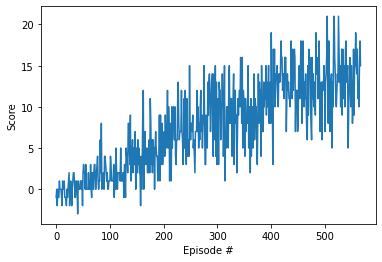

In [19]:
vanilla_agent = VanillaAgent(
    state_size=state_size,
    action_size=action_size,
    seed=0)

train(agent=vanilla_agent, file_name="vanilla.pth")

In [20]:
vanilla_agent = VanillaAgent(
    state_size=state_size,
    action_size=action_size,
    seed=0)

test(agent=vanilla_agent, file_name="vanilla.pth")

Score: 7.0


### 6. Double Deep Q-Network

In [11]:
class DoubleQAgent(VanillaAgent):
    def __init__(self, state_size, action_size, seed):
        super(DoubleQAgent, self).__init__(state_size, action_size, seed)
    

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        
        states, actions, rewards, next_states, dones = experiences
        
        targets = rewards + (1.0 - dones) * gamma \
            * self.qnetwork_target.forward(next_states).gather(
                1,
                self.qnetwork_local(next_states).max(1)[1].unsqueeze(1))
        
        targets = targets.detach()
        
        outputs = self.qnetwork_local.forward(states).gather(1, actions)
                      
        loss = F.mse_loss(outputs, targets)
        
        self.optimizer_local.zero_grad()
        loss.backward()      
        self.optimizer_local.step()
      
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)

Episode 100	Average Score: 0.76
Episode 200	Average Score: 4.59
Episode 300	Average Score: 7.09
Episode 400	Average Score: 10.44
Episode 483	Average Score: 13.08
Environment solved in 383 episodes!	Average Score: 13.08


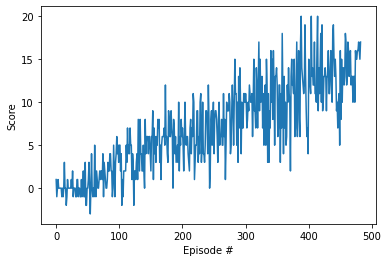

In [25]:
double_q_agent = DoubleQAgent(
    state_size=state_size,
    action_size=action_size,
    seed=0)

train(agent=double_q_agent, file_name="double_q.pth")

In [26]:
double_q_agent = DoubleQAgent(
    state_size=state_size,
    action_size=action_size,
    seed=0)

test(agent=double_q_agent, file_name="double_q.pth")

Score: 10.0


### 7. Dueling Deep Q-Network

In [15]:
class DuelingQNetwork(nn.Module):
    """Vanilla Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(DuelingQNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)

        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3_a = nn.Linear(64, 8)
        self.fc3_v = nn.Linear(64, 8)
        self.fc4_a = nn.Linear(8, action_size)
        self.fc4_v = nn.Linear(8, 1)

        
    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        a = self.fc3_a(x)
        v = self.fc3_v(x)
        a = F.relu(a)
        v = F.relu(v)
        a = self.fc4_a(a)
        v = self.fc4_v(v)
        
        return a + v - torch.mean(a, dim=1).reshape(-1, 1)

In [16]:
class DuelingQAgent(DoubleQAgent):
    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = DuelingQNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = DuelingQNetwork(state_size, action_size, seed).to(device)
        self.optimizer_local = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
        self.optimizer_target = optim.Adam(self.qnetwork_target.parameters(), lr=LR)
        
        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

Episode 100	Average Score: 0.81
Episode 200	Average Score: 4.38
Episode 300	Average Score: 7.82
Episode 400	Average Score: 10.54
Episode 471	Average Score: 13.04
Environment solved in 371 episodes!	Average Score: 13.04


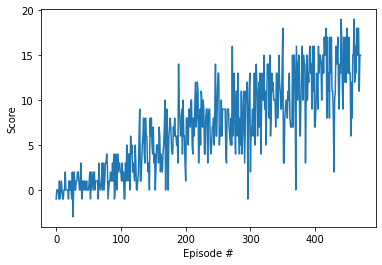

In [17]:
dueling_q_agent = DuelingQAgent(
    state_size=state_size,
    action_size=action_size,
    seed=0)

train(agent=dueling_q_agent, file_name="dueling_q.pth")

In [18]:
dueling_q_agent = DuelingQAgent(
    state_size=state_size,
    action_size=action_size,
    seed=0)

test(agent=dueling_q_agent, file_name="dueling_q.pth")

Score: 11.0


### 8. Prioritized Replay

### 9. Asynchronous Method for Deep Learning

### 10. Distributed Q-Value Estimation

### 11. Noisy Network

### 12. Conclusions

In [27]:
env.close()